In [1]:
from importlib import reload
from rlxutils import subplots
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

import omegaconf
from loguru import logger
from omegaconf import DictConfig, OmegaConf
import hydra
from progressbar import progressbar as pbar

from earthtext.datamodules import chipmultilabel

from importlib import reload
reload(chipmultilabel)

from earthtext.osm import multilabel
name_dict = multilabel.kvmerged.inverse_codes

# Train on all OSM classes

In [2]:
conf = OmegaConf.load("../../configs/multilabel.yaml")
conf.dataloader.batch_size = 16
dl = hydra.utils.instantiate(conf.dataloader)

2024-04-30 17:06:47.810 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1088 - checking chip files for train split
100% (58690 of 58690) |##################| Elapsed Time: 0:00:03 Time:  0:00:030000
2024-04-30 17:06:51.185 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1092 - read train split with 58599 chip files (out of 58690)
2024-04-30 17:06:51.186 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1097 - max cache size is -1
2024-04-30 17:06:51.554 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1088 - checking chip files for val split
100% (11841 of 11841) |##################| Elapsed Time: 0:00:00 Time:  0:00:000000
2024-04-30 17:06:52.221 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1092 - read val split with 11822 chip files (out of 11841)
2024-04-30 17:06:52.221 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1097 - max cache size is -1
2024-04-

In [3]:
dltrain = dl.train_dataloader()
m = hydra.utils.instantiate(conf.model)
optimizer = torch.optim.Adam(m.parameters(), lr=1e-5)
sum([np.product(p.shape) for p in m.parameters()])

570723

In [4]:
n_epochs = 50

lossh = []
for epoch in range(n_epochs):
    for step, batch in enumerate(dltrain):
        # extract data from batch
        x = batch['embedding']
        t = batch['multilabel']

        # run model
        o = m(x)

        # compute losses (complex mse or rmse)
        loss = - torch.mean(torch.log(o + 1e-5)*t + torch.log(1-o + 1e-5)*(1-t))
        
        # backpropage and update
        loss.backward()
        optimizer.step()
        
        # cosmetics
        lossn = loss.detach().cpu().numpy()
        lossh.append(lossn)
        psummary = np.mean([(p.abs().mean().detach().cpu().numpy()) for p in m.parameters()])    
        lossm = np.mean(lossh[-50:])
        print(f"epoch {epoch:3} step {step:3d} loss {lossm:.5f} params {psummary:.7f}", end="\r")
        
    print()

epoch   0 step 3662 loss 0.17864 params 0.0378007
epoch   1 step 3662 loss 0.16534 params 0.0554687
epoch   2 step 3662 loss 0.14697 params 0.0788702
epoch   3 step 3662 loss 0.15457 params 0.1023702
epoch   4 step 3662 loss 0.14750 params 0.1260398
epoch   5 step 3662 loss 0.14603 params 0.1499260
epoch   6 step 3662 loss 0.14959 params 0.1740085
epoch   7 step 3662 loss 0.15140 params 0.1989730
epoch   8 step 3662 loss 0.13500 params 0.2242990
epoch   9 step 3662 loss 0.14699 params 0.2494475
epoch  10 step 3662 loss 0.14493 params 0.2747092
epoch  11 step 3662 loss 0.14438 params 0.2999777
epoch  12 step 3662 loss 0.14329 params 0.3252698
epoch  13 step 3662 loss 0.14402 params 0.3505729
epoch  14 step 3662 loss 0.14153 params 0.3759188
epoch  15 step 3662 loss 0.14205 params 0.4012018
epoch  16 step 3662 loss 0.14124 params 0.4265627
epoch  17 step 3662 loss 0.13437 params 0.4518994
epoch  18 step 3662 loss 0.14592 params 0.4769675
epoch  19 step 3662 loss 0.14095 params 0.5022933


Text(0, 0.5, 'loss')

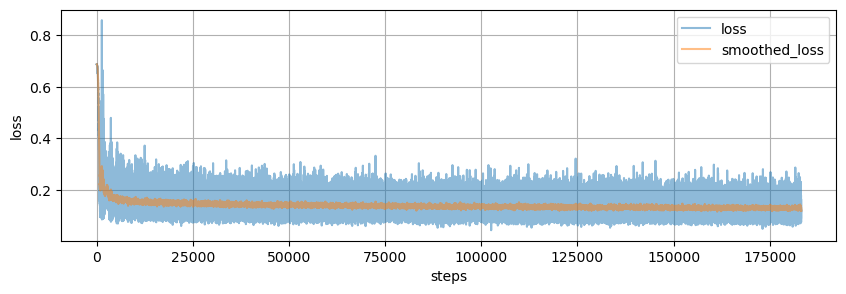

In [5]:
lossp = pd.DataFrame(lossh, columns=['loss'])
lossp['smoothed_loss'] = lossp.loss.rolling(50).mean()
lossp.plot(alpha=.5, figsize=(10,3))
plt.grid(); plt.xlabel("steps"); plt.ylabel("loss")

In [174]:
targets = []
predictions = []
dltrain = dl.train_dataloader()
for batch in pbar(dltrain):
    x = batch['embedding']
    t = batch['multilabel']

    o = m(x)

    for ti in t.detach().numpy():
        targets.append(ti)

    for oi in o.detach().numpy():
        predictions.append(oi)
    
targets = np.r_[targets]
predictions = np.r_[predictions]
targets.shape, predictions.shape

100% (3663 of 3663) |####################| Elapsed Time: 0:00:11 Time:  0:00:110001


((58599, 99), (58599, 99))

In [7]:
idxs = np.random.permutation(len(targets))[:300]

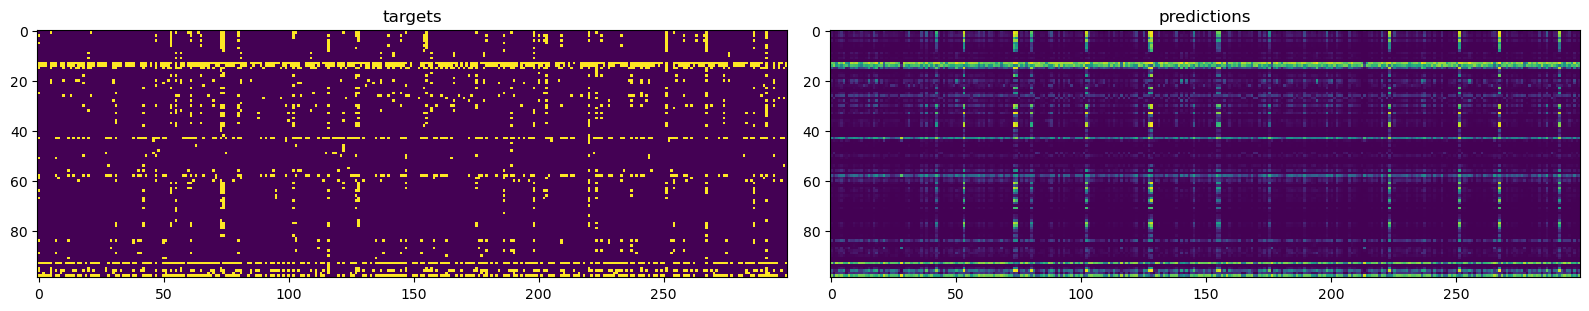

In [8]:
for ax, i in subplots(2, usizex=8):
    if i==0: 
        plt.imshow(targets[idxs].T, interpolation='none')
        plt.title("targets")
    if i==1:
        plt.imshow(predictions[idxs].T, interpolation='none', vmin=0, vmax=1)
        plt.title("predictions")
        #plt.colorbar();

In [33]:
from sklearn.metrics import precision_score, recall_score

tpr = lambda y_true, y_pred: np.mean(y_true[y_true==1] == y_pred[y_true==1])
tnr = lambda y_true, y_pred: np.mean(y_true[y_true==0] == y_pred[y_true==0])
prec = lambda y_true, y_pred: sum(y_true[y_pred==1]) / sum(y_pred==1) if sum(y_pred==1)>0 else None

acc = lambda y_true, y_pred: np.mean(y_true==y_pred)
# 'tpr': 0.5767012011351924,
#  'tnr': 0.9821519242111034,
#  'acc': 0.9543408209300903,
#  'prec': 0.7041051529853083
metr = lambda y_true, y_pred: {'tpr': tpr(y_true, y_pred),
                               # 'tnr': tnr(y_true, y_pred),
                               # 'acc': acc(y_true, y_pred),
                               'prec': prec(y_true, y_pred)}

In [34]:
metr(targets.flatten(), predictions.flatten()>.5)

{'tpr': 0.49520932935494427, 'prec': 0.7343967265353418}

In [35]:
precision_score(targets.flatten(), predictions.flatten()>.5), \
recall_score(targets.flatten(), predictions.flatten()>.5)

(0.7343967265353418, 0.49520932935494427)

In [36]:
r = [metr(targets[:,c], predictions[:,c]>.5) for c in range(targets.shape[-1])]    
r = pd.DataFrame(r)

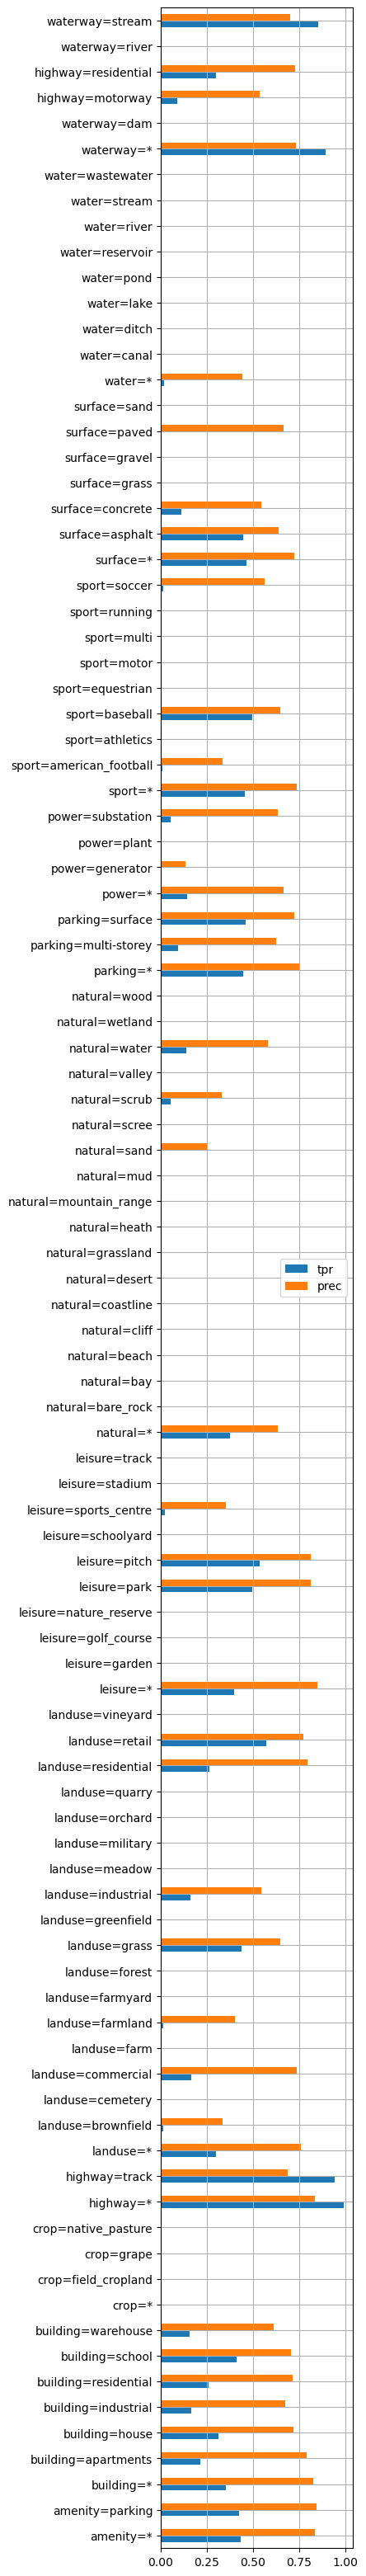

In [37]:
ax = r[['tpr', 'prec']].plot(kind='barh', figsize=(3,40), grid=True)
ax.set_yticklabels(labels=(name_dict[i] for i in range(99)), rotation=0, fontsize=10);

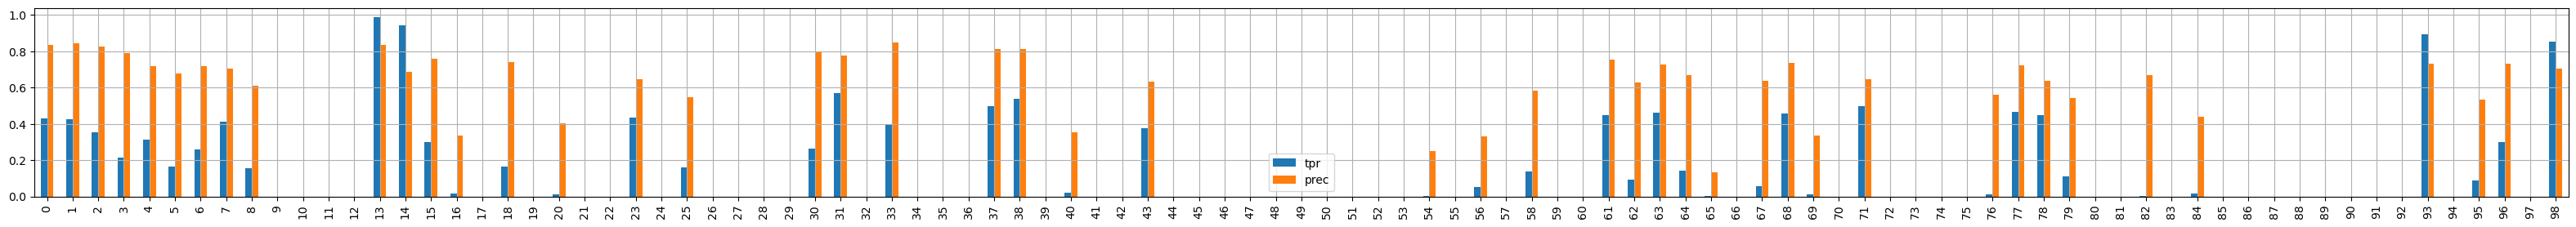

In [38]:
r[['tpr', 'prec']].plot(kind='bar', figsize=(40,3))
plt.grid()

IGNORE

Classes to discard due to recall < .1 :
- 9, 10, 11, 12, 16, 17, 19, 21, 22, 24, 26, 27, 28, 29, 32, 34, 35, 36, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 59, 60, 62, 65, 66, 67, 69, 70, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 84, 85, 86, 88, 89, 90, 91, 92, 94, 97

Classes to retain :
- 0, 1, 2, 3, 4, 5, 6, 7, 8, 13, 14, 15, 18, 20, 23, 25, 30, 31, 33, 37, 38, 43, 58, 61, 63, 64, 68, 71, 77, 78, 87, 93, 95, 96, 98

In [39]:
classes_retain = [0, 1, 2, 3, 4, 5, 6, 7, 8, 13,
                  14, 15, 18, 20, 23, 25, 30, 31, 33, 37,
                  38, 43, 58, 61, 63, 64, 68, 71, 77, 78,
                  87, 93, 95, 96, 98]

In [40]:
from earthtext.osm import multilabel
name_dict = multilabel.kvmerged.inverse_codes

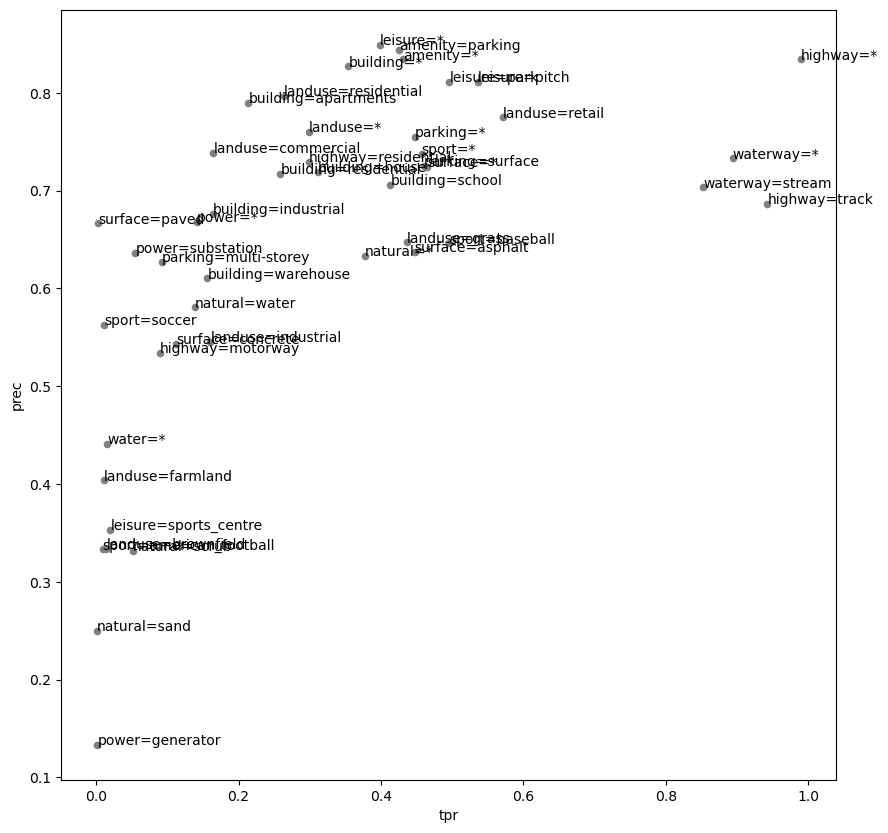

In [41]:
ax = r[['tpr', 'prec']].plot(kind='scatter', x='tpr', y='prec', c='gray', figsize=(10,10))

for i in range(len(np.array(r.tpr))):
    if not np.isnan(np.array(r.prec)[i]):
        # ax.text(x=np.array(r.tpr)[i], y=np.array(r.prec)[i], s=list(r.index)[i])
        ax.text(x=np.array(r.tpr)[i], y=np.array(r.prec)[i], s=name_dict[list(r.index)[i]], size=10)

---

In [70]:
R = []
for thres in pbar(np.linspace(0, .99, 100)):
    r = [metr(targets[:,c], predictions[:,c] >= thres) for c in range(targets.shape[-1])]    
    r = pd.DataFrame(r)
    R.append(r)

R = np.array([r.values for r in R])
R.shape

(100, 99, 2)

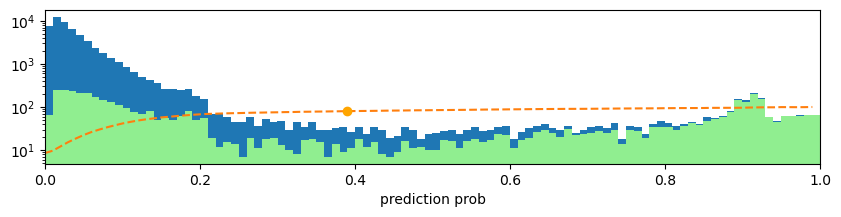

In [225]:
fig = plt.figure(figsize=(10, 2));
# print(targets[:, c].sum())
c = 1
plt.hist(predictions[:, c], bins=100);
plt.hist(predictions[targets[:, c] > 0, c], bins=100, color='lightgreen');
plt.plot(np.linspace(0, .99, 100), R[:, c, 1]*100, '--');
plt.yscale('log'); plt.xlabel('prediction prob'); plt.xlim(0,1);

i_nz = (R[:, c, 1] >= .8).nonzero()[0][0]
plt.plot(i_nz/100, R[i_nz, c, 1]*100, 'o', color='orange');

In [175]:
targets2 = targets.copy()

In [181]:
c = 1
targets2[predictions[:, c] < .2, c] = 0

Classes to retain based on the below

In [2]:
classes_retain = [2, 3, 4, 5, 6, 7, 8, 13, 14, 18,
                  23, 30, 33, 37, 43, 58, 61, 68, 71, 84,
                  93, 95, 96, 97, 98]

print(len(classes_retain))
for c in classes_retain:
    print(c, name_dict[c])

25
2 building=*
3 building=apartments
4 building=house
5 building=industrial
6 building=residential
7 building=school
8 building=warehouse
13 highway=*
14 highway=track
18 landuse=commercial
23 landuse=grass
30 landuse=residential
33 leisure=*
37 leisure=park
43 natural=*
58 natural=water
61 parking=*
68 sport=*
71 sport=baseball
84 water=*
93 waterway=*
95 highway=motorway
96 highway=residential
97 waterway=river
98 waterway=stream


<Figure size 640x480 with 0 Axes>

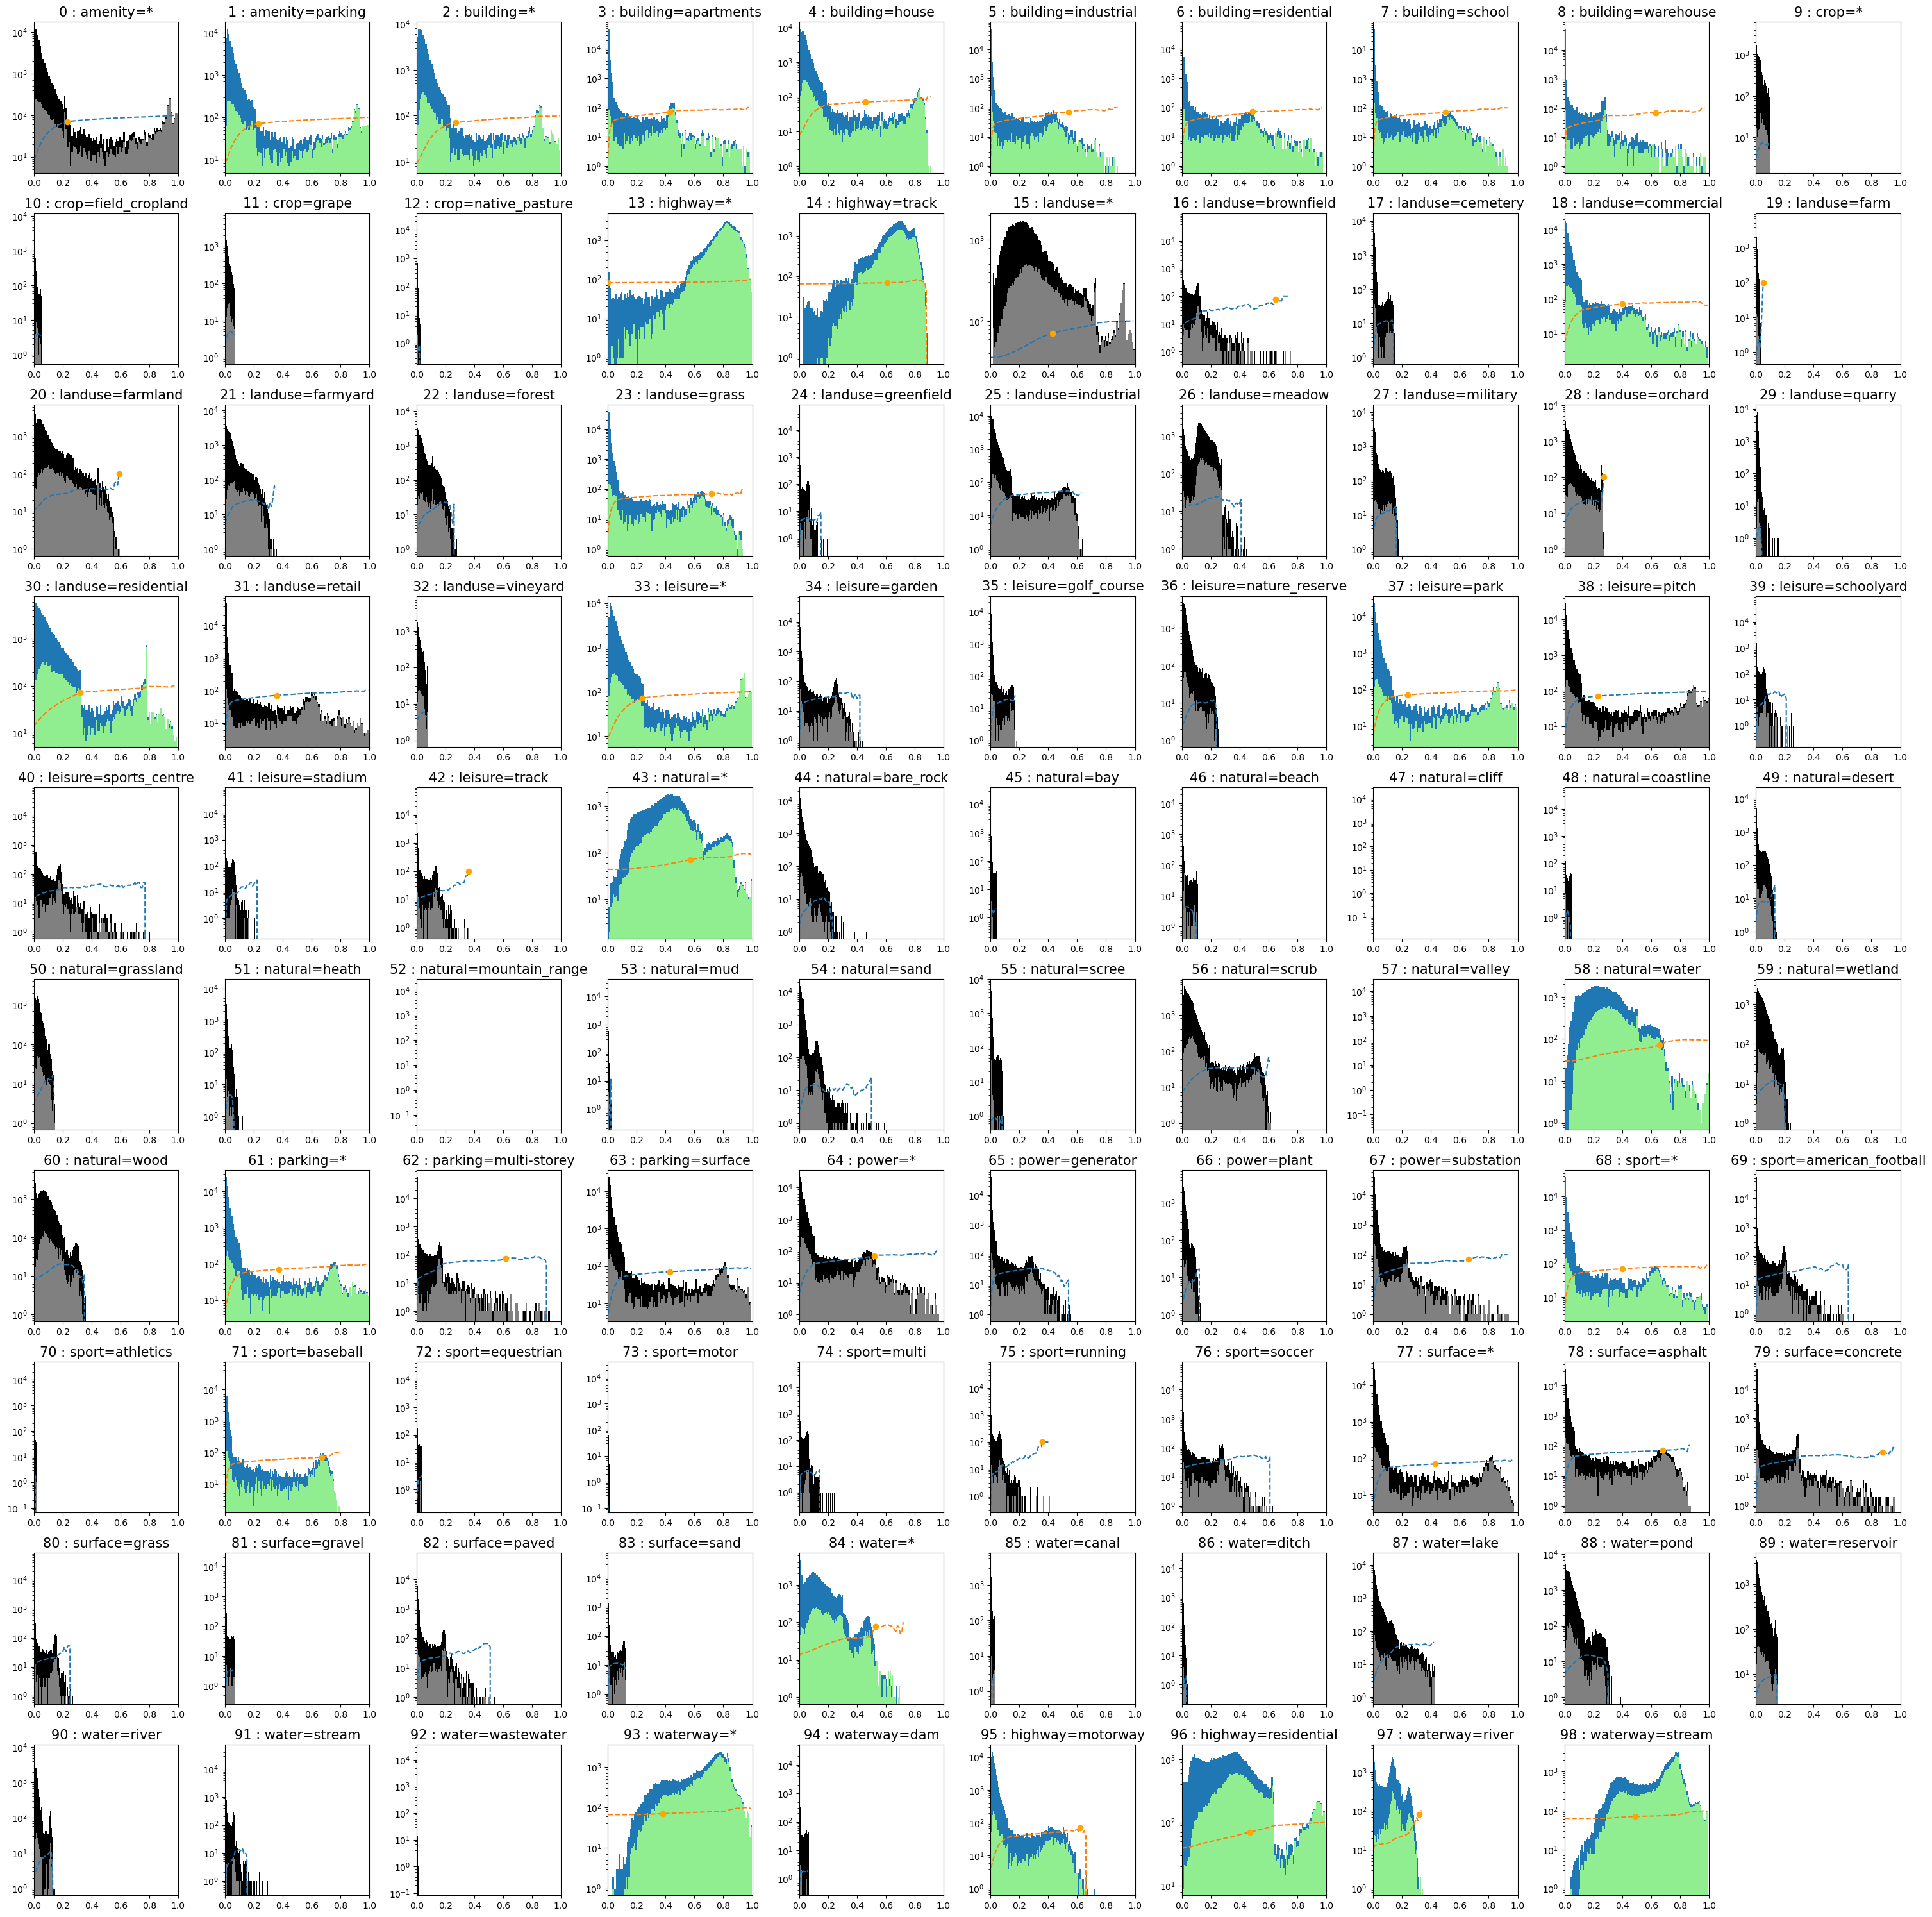

In [265]:
fig = plt.figure();
for ax, c in subplots(99, n_cols=10, usizex=3, usizey=3):
    if c in classes_retain:
        plt.hist(predictions[:, c], bins=100);
        plt.hist(predictions[targets[:, c] > 0, c], bins=100, color='lightgreen');
    else:
        plt.hist(predictions[:, c], bins=100, color='black');
        plt.hist(predictions[targets[:, c] > 0, c], bins=100, color='gray');
    plt.plot(np.linspace(0, .99, 100), R[:, c, 1]*100, '--');
    is_high_prec = (R[:, c, 1] >= .7)
    if is_high_prec.sum() > 0:
        i_nz = is_high_prec.nonzero()[0][0]
        plt.plot(i_nz/100, R[i_nz, c, 1]*100, 'o', color='orange');
    plt.yscale('log');
    plt.xlim(0,1); plt.title(f"{c} : {name_dict[c]}", fontsize=15);

<Figure size 640x480 with 0 Axes>

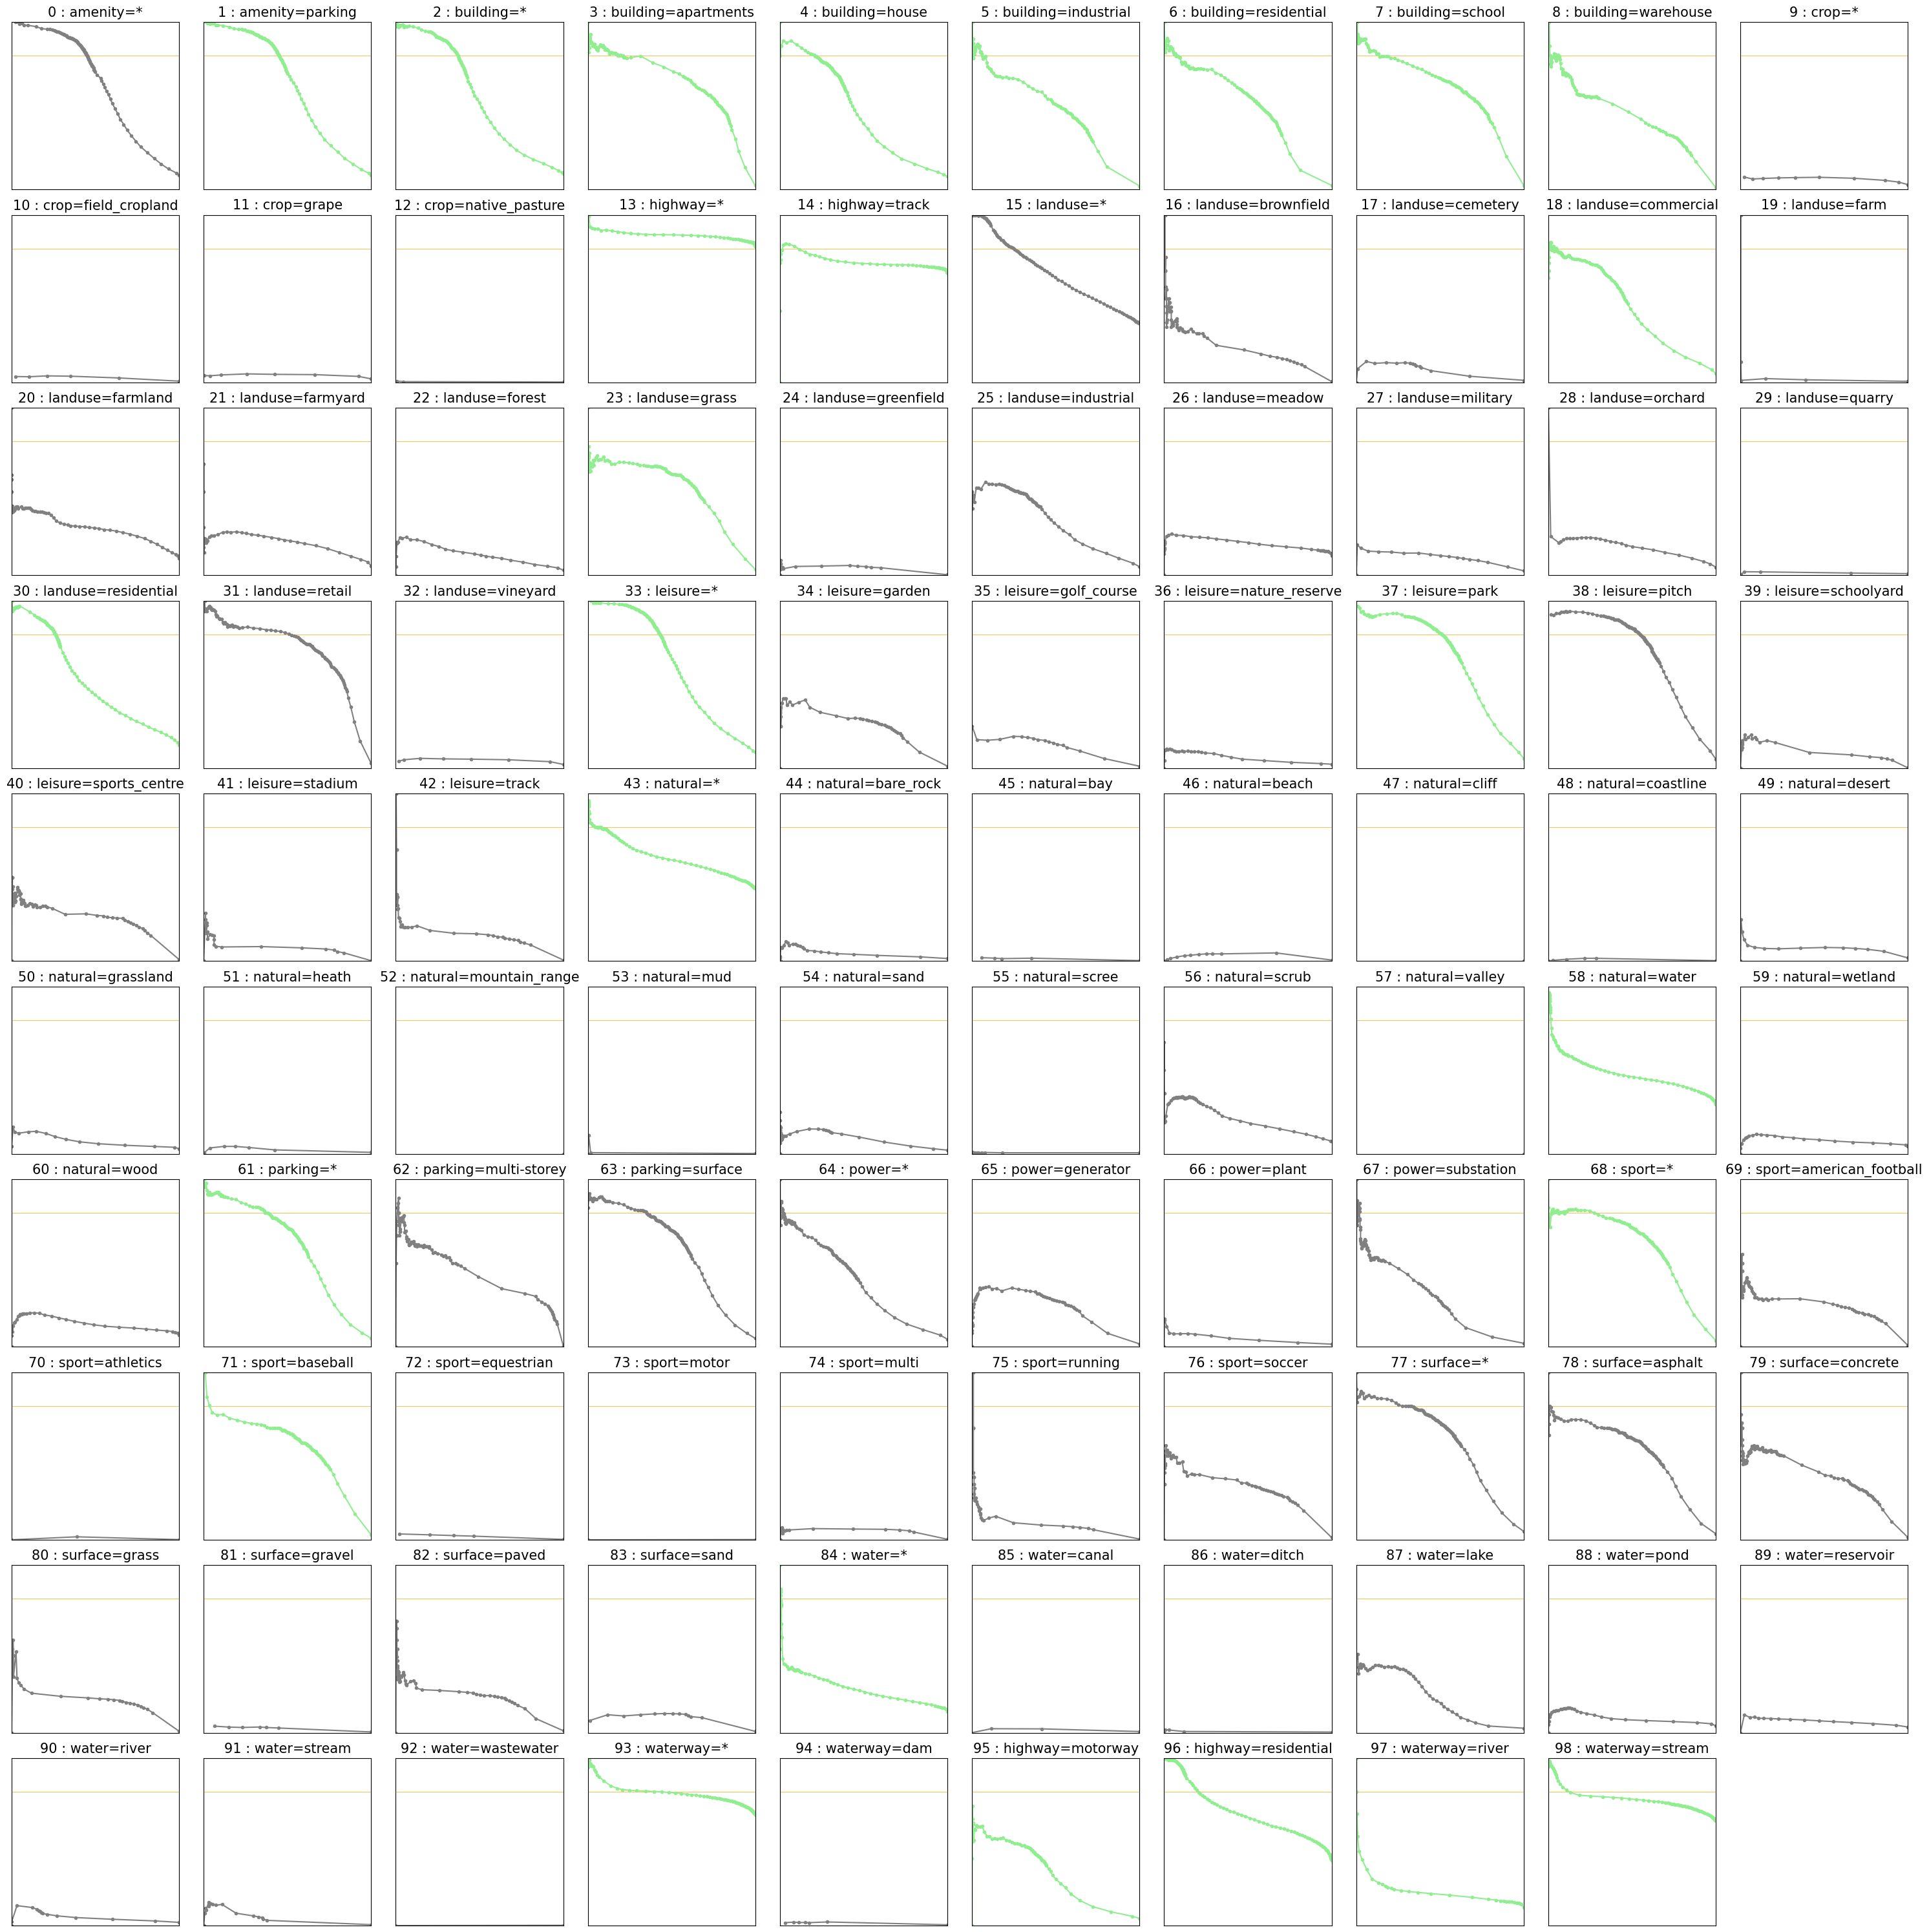

In [266]:
fig = plt.figure();
for ax, c in subplots(99, n_cols=10, usizex=3, usizey=3):
    ax.plot([0,1], [.8,.8], lw=.5, c='orange');
    ax.set_title(f"{c} : {name_dict[c]}", fontsize=15);
    ax.set_xlim(0, 1); ax.set_ylim(0, 1); ax.set_yticks([]); ax.set_xticks([]); ax.set_aspect('equal');
    if c in classes_retain:
        ax.plot(*R[:, c, :].T, marker='o', ls='-', markersize=3, color='lightgreen');
    else:
        ax.plot(*R[:, c, :].T, marker='o', ls='-', markersize=3, color='gray');
plt.tight_layout();

Cut-off probabilities

In [269]:
prob_cutoff = {}
for c in classes_retain:
    is_high_prec = (R[:, c, 1] >= .7)
    if is_high_prec.sum() > 0:
        i_nz = is_high_prec.nonzero()[0][0]
        prob_cutoff[c] = i_nz / 100
print(len(prob_cutoff))
print(prob_cutoff)

targets2 = targets.copy()
for c in prob_cutoff:
    i_alter = (predictions[:, c] < prob_cutoff[c])
    targets2[i_alter, c] = 0

26
{1: 0.23, 2: 0.27, 3: 0.43, 4: 0.46, 5: 0.54, 6: 0.49, 7: 0.5, 8: 0.63, 13: 0.0, 14: 0.61, 18: 0.4, 23: 0.72, 30: 0.32, 33: 0.24, 37: 0.24, 43: 0.57, 58: 0.66, 61: 0.37, 68: 0.4, 71: 0.67, 84: 0.53, 93: 0.38, 95: 0.62, 96: 0.47, 97: 0.32, 98: 0.49}


---

# Retrain only on retained classes

In [75]:
for c in classes_retain:
    print(name_dict[c])

building=*
building=apartments
building=house
building=industrial
building=residential
building=school
building=warehouse
highway=*
highway=track
landuse=commercial
landuse=grass
landuse=residential
leisure=*
leisure=park
natural=*
natural=water
parking=*
sport=*
sport=baseball
water=*
waterway=*
highway=motorway
highway=residential
waterway=river
waterway=stream


In [76]:
conf = OmegaConf.load("../../configs/multilabel.yaml")
conf.dataloader.batch_size = 16
conf.model.output_dim = len(classes_retain)
dl = hydra.utils.instantiate(conf.dataloader)

2024-04-30 23:26:43.284 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1088 - checking chip files for train split
100% (58690 of 58690) |##################| Elapsed Time: 0:00:03 Time:  0:00:030000
2024-04-30 23:26:46.587 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1092 - read train split with 58599 chip files (out of 58690)
2024-04-30 23:26:46.588 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1097 - max cache size is -1
2024-04-30 23:26:46.980 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1088 - checking chip files for val split
100% (11841 of 11841) |##################| Elapsed Time: 0:00:00 Time:  0:00:000000
2024-04-30 23:26:47.646 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1092 - read val split with 11822 chip files (out of 11841)
2024-04-30 23:26:47.647 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1097 - max cache size is -1
2024-04-

In [77]:
dltrain = dl.train_dataloader()
m = hydra.utils.instantiate(conf.model)
optimizer = torch.optim.Adam(m.parameters(), lr=1e-5)
sum([np.product(p.shape) for p in m.parameters()])

561177

In [78]:
n_epochs = 50

lossh = []
for epoch in range(n_epochs):
    for step, batch in enumerate(dltrain):
        # extract data from batch
        x = batch['embedding']
        t = batch['multilabel'][:, classes_retain]

        # run model
        o = m(x)

        # compute losses (complex mse or rmse)
        loss = - torch.mean(torch.log(o + 1e-5)*t + torch.log(1-o + 1e-5)*(1-t))
        
        # backpropage and update
        loss.backward()
        optimizer.step()
        
        # cosmetics
        lossn = loss.detach().cpu().numpy()
        lossh.append(lossn)
        psummary = np.mean([(p.abs().mean().detach().cpu().numpy()) for p in m.parameters()])    
        lossm = np.mean(lossh[-50:])
        print(f"epoch {epoch:3} step {step:3d} loss {lossm:.5f} params {psummary:.7f}", end="\r")
        
    print()

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f27dbaf1620>
Traceback (most recent call last):
  File "/opt/conda/envs/earth-text-env/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/envs/earth-text-env/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/opt/conda/envs/earth-text-env/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f27dbaf1620>
Traceback (most recent call last):
  File "/opt/conda/envs/earth-text-env/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/envs/earth-text-env/lib/py

epoch   0 step 3662 loss 0.33683 params 0.0372470
epoch   1 step 3662 loss 0.30615 params 0.0557890
epoch   2 step 3662 loss 0.30470 params 0.0790699
epoch   3 step 3662 loss 0.30345 params 0.1029922
epoch   4 step 3662 loss 0.30423 params 0.1274658
epoch   5 step 3662 loss 0.30099 params 0.1522851
epoch   6 step 3662 loss 0.29620 params 0.1771350
epoch   7 step 3662 loss 0.28147 params 0.2023816
epoch   8 step 3662 loss 0.28030 params 0.2283867
epoch   9 step 3662 loss 0.29348 params 0.2548777
epoch  10 step 3662 loss 0.29550 params 0.2812759
epoch  11 step 3662 loss 0.28845 params 0.3076796
epoch  12 step 3662 loss 0.27021 params 0.3339462
epoch  13 step 3662 loss 0.28589 params 0.3599974
epoch  14 step 3662 loss 0.27330 params 0.3859054
epoch  15 step 3662 loss 0.27195 params 0.4118817
epoch  16 step 3662 loss 0.28721 params 0.4373528
epoch  17 step 3662 loss 0.27796 params 0.4624440
epoch  18 step 3662 loss 0.27065 params 0.4875270
epoch  19 step 3662 loss 0.27539 params 0.5123580


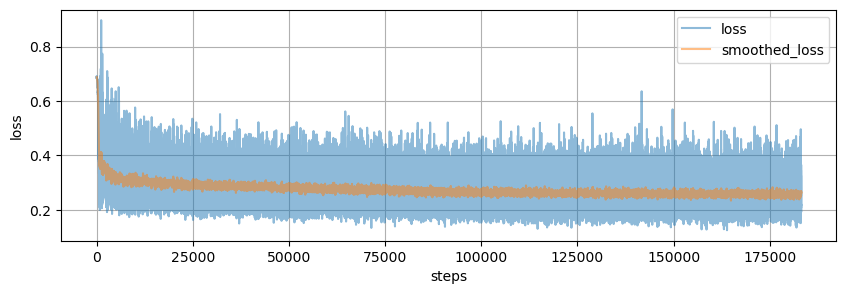

In [79]:
lossp = pd.DataFrame(lossh, columns=['loss'])
lossp['smoothed_loss'] = lossp.loss.rolling(50).mean()
lossp.plot(alpha=.5, figsize=(10,3))
plt.grid(); plt.xlabel("steps"); plt.ylabel("loss");

In [80]:
targets = []
predictions = []
dltrain = dl.train_dataloader()
# dltrain = dl.test_dataloader()
for batch in pbar(dltrain):
    x = batch['embedding']
    t = batch['multilabel'][:, classes_retain]

    o = m(x)

    for ti in t.detach().numpy():
        targets.append(ti)

    for oi in o.detach().numpy():
        predictions.append(oi)
    
targets = np.r_[targets]
predictions = np.r_[predictions]
targets.shape, predictions.shape

100% (3663 of 3663) |####################| Elapsed Time: 0:00:14 Time:  0:00:140001


((58599, 25), (58599, 25))

In [81]:
idxs = np.random.permutation(len(targets))[:300]

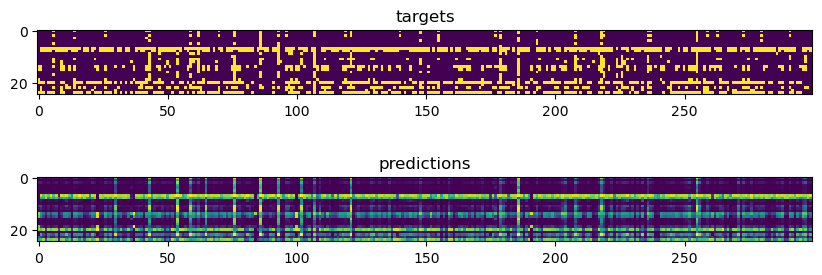

In [82]:
fig, ax = plt.subplots(2, 1, figsize=(10,3.5));
ax[0].imshow(targets[idxs].T, interpolation='none');
ax[0].set_title("targets");
ax[1].imshow(predictions[idxs].T, interpolation='none');
ax[1].set_title("predictions");
# fig.tight_layout()

In [83]:
from sklearn.metrics import precision_score, recall_score

tpr = lambda y_true, y_pred: np.mean(y_true[y_true==1] == y_pred[y_true==1])
prec = lambda y_true, y_pred: sum(y_true[y_pred==1]) / sum(y_pred==1) if sum(y_pred==1)>0 else None
metr = lambda y_true, y_pred: {'tpr': tpr(y_true, y_pred), 'prec': prec(y_true, y_pred)}

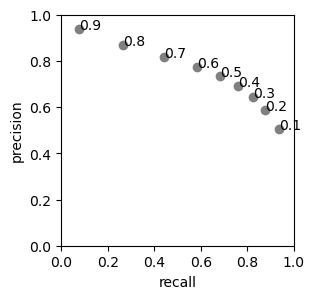

In [84]:
fig = plt.figure(figsize=(3, 3))
for thres in np.arange(.1, 1, .1):
    _rp = metr(targets.flatten(), predictions.flatten()>thres)
    _rec = _rp['tpr']
    _prec = _rp['prec']
    plt.scatter(_rec, _prec, c='gray');
    plt.text(_rec, _prec, round(thres, 1));
plt.xlabel("recall"); plt.ylabel("precision"); plt.xlim(0,1); plt.ylim(0,1);

In [85]:
R = []
for thres in np.linspace(0, .99, 100):
    r = [metr(targets[:,c], predictions[:,c] >= thres) for c in range(targets.shape[-1])]    
    r = pd.DataFrame(r)
    R.append(r)

R = np.array([r.values for r in R])
R.shape

(100, 25, 2)

---

In [86]:
from earthtext.osm import multilabel
name_dict = multilabel.kvmerged.inverse_codes

<Figure size 640x480 with 0 Axes>

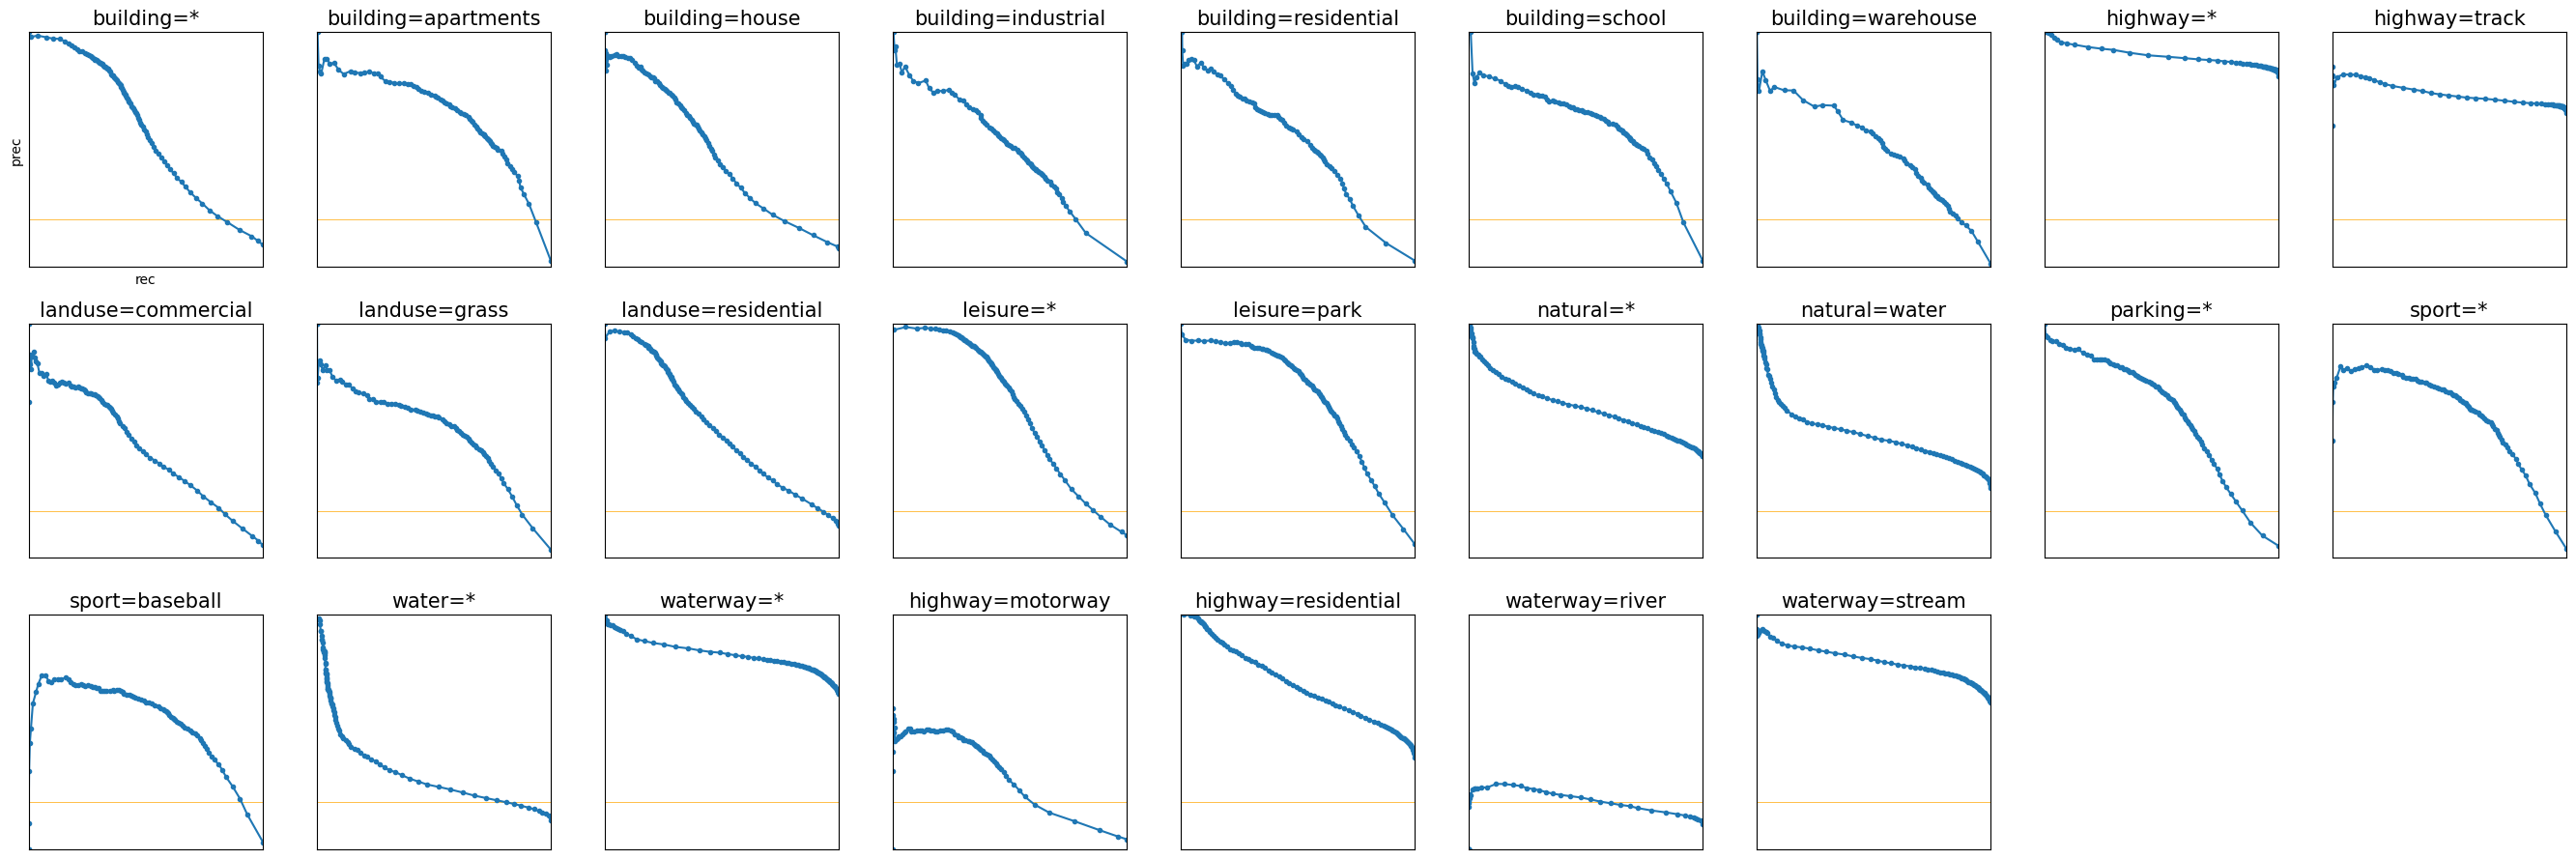

In [87]:
fig = plt.figure();
for ax, c in subplots(len(classes_retain), n_cols=9, usizex=3, usizey=3):
    ax.plot([0,1], [.2,.2], lw=.5, c='orange');
    ax.set_title(name_dict[classes_retain[c]], fontsize=15);
    ax.set_xlim(0, 1); ax.set_ylim(0, 1);
    # if c != 0:
    ax.set_yticks([]); ax.set_xticks([]);
    ax.set_aspect('equal')
    if c == 0:
        ax.set_xlabel('rec', fontsize=10); ax.set_ylabel('prec', fontsize=10);
    ax.plot(*R[:, c, :].T, marker='o', ls='-', markersize=3);
    # for i, thres in enumerate(np.linspace(0.1, 1, 10)):
    #     if None not in R[i, c, :] and np.isfinite(list(R[i, c, :])).all():
    #         ax.text(*R[i, c, :], f"{thres:.1f}", fontsize=10)
plt.tight_layout();

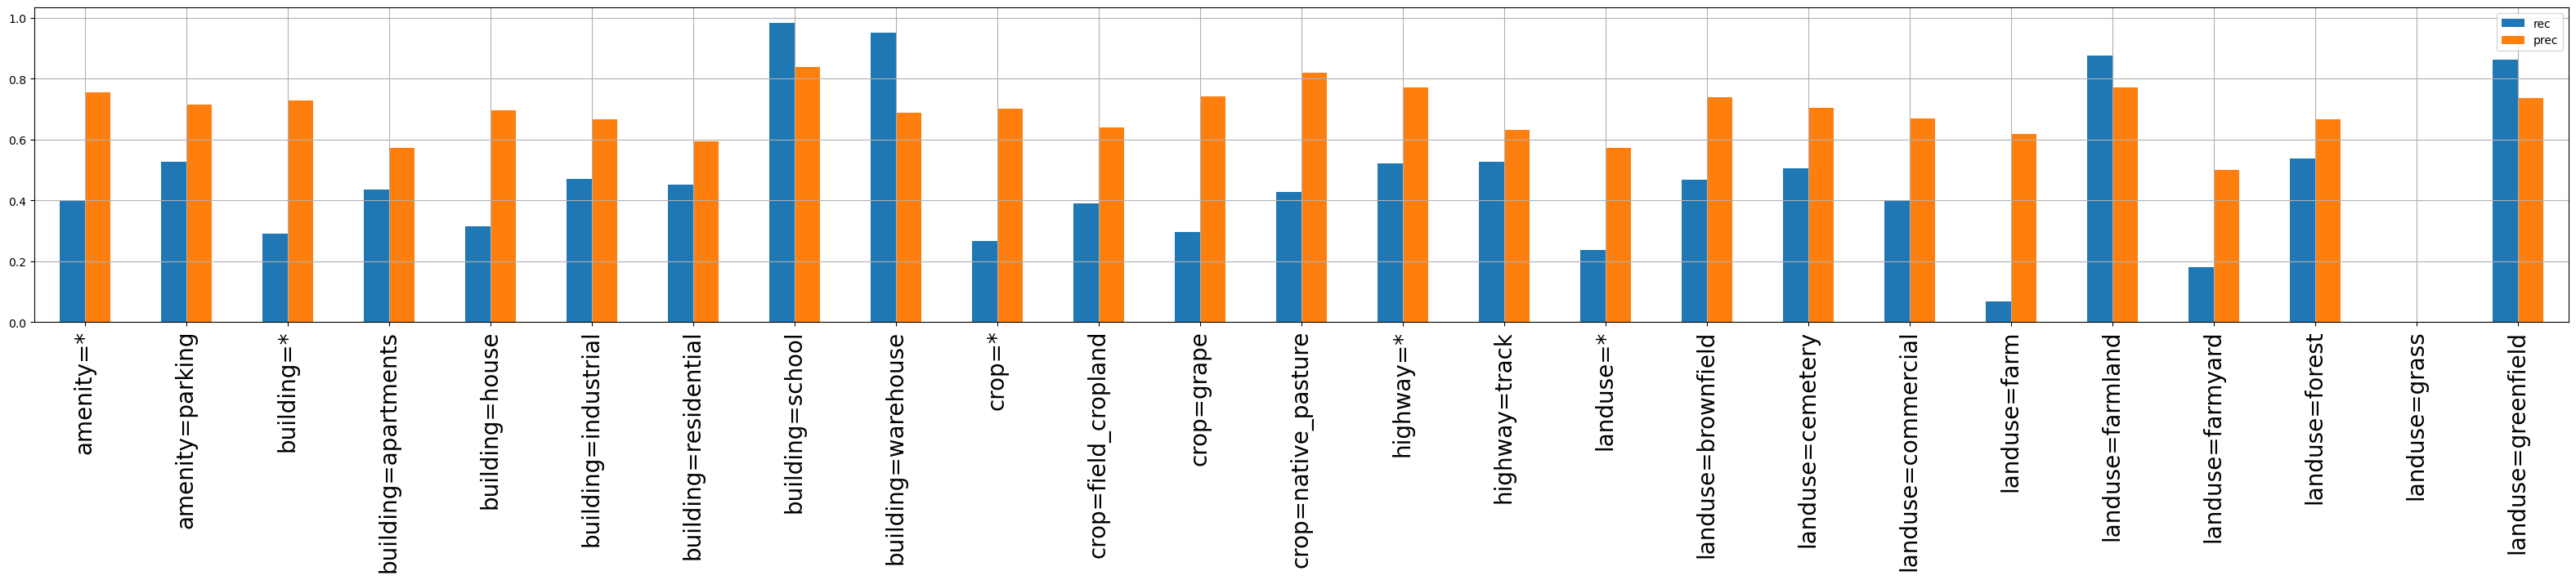

In [88]:
ax = pd.DataFrame(R[50], columns=['rec', 'prec']).plot(kind='bar', figsize=(40,5), grid=True);
ax.set_xticklabels(labels=(name_dict[i] for i in range(len(classes_retain))), rotation=90, fontsize=20);

# Retrain on retained classes and modified targets

In [89]:
R.shape

(100, 25, 2)

In [90]:
prob_cutoff = {}
for i, c in enumerate(classes_retain):
    is_high_prec = (R[:, i, 1] >= .2)
    if is_high_prec.sum() > 0:
        i_nz = is_high_prec.nonzero()[0][0]
        prob_cutoff[c] = i_nz / 100
print(len(prob_cutoff))
print(prob_cutoff)

targets2 = targets.copy()
for i, c in enumerate(prob_cutoff):
    i_alter = (predictions[:, i] < prob_cutoff[c])
    targets2[i_alter, i] = 0

25
{2: 0.05, 3: 0.02, 4: 0.06, 5: 0.02, 6: 0.03, 7: 0.02, 8: 0.05, 13: 0.0, 14: 0.0, 18: 0.06, 23: 0.03, 30: 0.06, 33: 0.04, 37: 0.03, 43: 0.0, 58: 0.0, 61: 0.03, 68: 0.03, 71: 0.02, 84: 0.1, 93: 0.0, 95: 0.06, 96: 0.0, 97: 0.14, 98: 0.0}


In [100]:
T = torch.Tensor(targets2)
T.shape

torch.Size([58599, 25])

In [101]:
X = torch.Tensor()
# T = torch.Tensor()
# dltrain = dl.train_dataloader()
for batch in pbar(dltrain):
    x = batch['embedding']
    X = torch.concat([X, x])
    # t = batch['multilabel'][:, classes_retain]
    # T = torch.concat([T, t])

X.shape, T.shape

100% (3663 of 3663) |####################| Elapsed Time: 0:00:30 Time:  0:00:300002


(torch.Size([58599, 768]), torch.Size([58599, 25]), torch.Size([58599, 25]))

In [128]:
m = hydra.utils.instantiate(conf.model)
optimizer = torch.optim.Adam(m.parameters(), lr=1e-5)
sum([np.product(p.shape) for p in m.parameters()])

561177

In [129]:
n_epochs = 10000

lossh = []
for epoch in range(n_epochs):
    # run model
    O = m(X)
    # compute losses (complex mse or rmse)
    loss = - torch.mean(torch.log(O + 1e-5)*T + torch.log(1-O + 1e-5)*(1-T))
    
    # backpropage and update
    loss.backward()
    optimizer.step()

    # cosmetics
    lossn = loss.detach().cpu().numpy()
    lossh.append(lossn)
    psummary = np.mean([(p.abs().mean().detach().cpu().numpy()) for p in m.parameters()])    
    lossm = np.mean(lossh[-50:])
    print(f"epoch {epoch:3} step {step:3d} loss {lossm:.5f} params {psummary:.7f}", end="\r")
        
    print()

epoch   0 step 3662 loss 0.69355 params 0.0287215
epoch   1 step 3662 loss 0.69353 params 0.0287215
epoch   2 step 3662 loss 0.69351 params 0.0287216
epoch   3 step 3662 loss 0.69349 params 0.0287217
epoch   4 step 3662 loss 0.69347 params 0.0287218
epoch   5 step 3662 loss 0.69345 params 0.0287219
epoch   6 step 3662 loss 0.69343 params 0.0287220
epoch   7 step 3662 loss 0.69341 params 0.0287221
epoch   8 step 3662 loss 0.69339 params 0.0287222
epoch   9 step 3662 loss 0.69337 params 0.0287223
epoch  10 step 3662 loss 0.69335 params 0.0287224
epoch  11 step 3662 loss 0.69333 params 0.0287225
epoch  12 step 3662 loss 0.69331 params 0.0287226
epoch  13 step 3662 loss 0.69329 params 0.0287227
epoch  14 step 3662 loss 0.69327 params 0.0287228
epoch  15 step 3662 loss 0.69325 params 0.0287229
epoch  16 step 3662 loss 0.69323 params 0.0287230
epoch  17 step 3662 loss 0.69321 params 0.0287231
epoch  18 step 3662 loss 0.69319 params 0.0287232
epoch  19 step 3662 loss 0.69317 params 0.0287234


KeyboardInterrupt: 

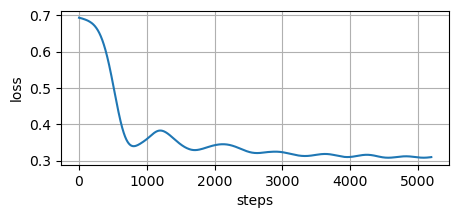

In [130]:
plt.figure(figsize=(5, 2));
plt.plot(lossh);
plt.grid(); plt.xlabel("steps"); plt.ylabel("loss");

In [106]:
targets = T.detach().numpy()
predictions = O.detach().numpy()
targets.shape, predictions.shape

((58599, 25), (58599, 25))

In [114]:
targets

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [111]:
idxs = np.random.permutation(len(targets))[:300]

In [116]:
len(targets)

58599

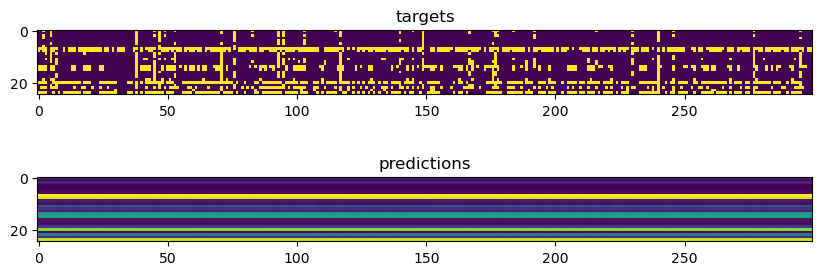

In [117]:
fig, ax = plt.subplots(2, 1, figsize=(10,3.5));
ax[0].imshow(targets[idxs].T, interpolation='none');
ax[0].set_title("targets");
ax[1].imshow(predictions[idxs].T, interpolation='none');
ax[1].set_title("predictions");
# fig.tight_layout()

In [126]:
R = []
for thres in np.linspace(0, .99, 100):
    r = [metr(targets[:,c], predictions[:,c] >= thres) for c in range(targets.shape[-1])]    
    r = pd.DataFrame(r)
    R.append(r)

R = np.array([r.values for r in R])
R.shape

(100, 25, 2)

<Figure size 640x480 with 0 Axes>

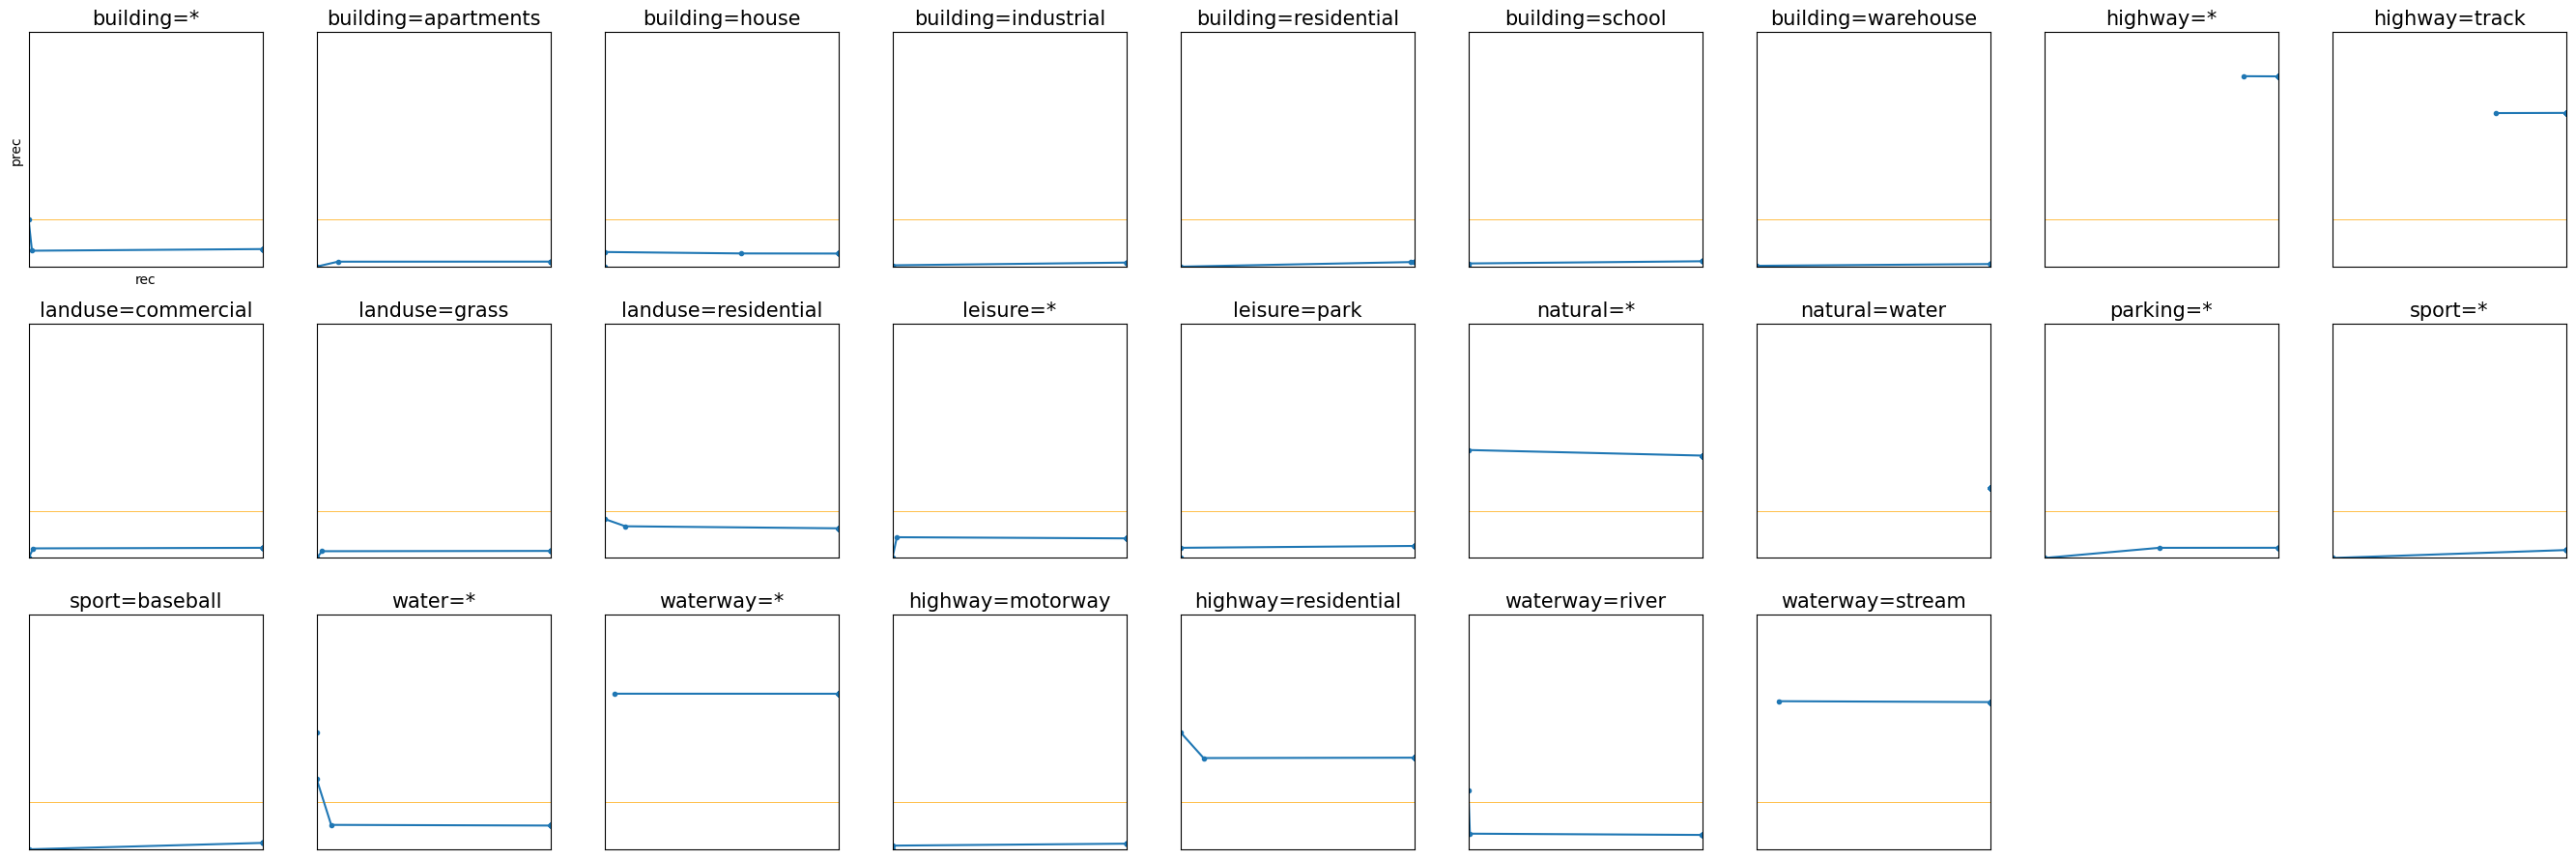

In [127]:
fig = plt.figure();
for ax, c in subplots(len(classes_retain), n_cols=9, usizex=3, usizey=3):
    ax.plot([0,1], [.2,.2], lw=.5, c='orange');
    ax.set_title(name_dict[classes_retain[c]], fontsize=15);
    ax.set_xlim(0, 1); ax.set_ylim(0, 1);
    # if c != 0:
    ax.set_yticks([]); ax.set_xticks([]);
    ax.set_aspect('equal')
    if c == 0:
        ax.set_xlabel('rec', fontsize=10); ax.set_ylabel('prec', fontsize=10);
    ax.plot(*R[:, c, :].T, marker='o', ls='-', markersize=3);
plt.tight_layout();